In [2]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import statsmodels.api as sm

In [2]:
working_df = pd.read_csv("working_sample_1.csv")

In [3]:
working_df_clean = working_df.drop(columns="Unnamed: 0")
print(working_df_clean)

             date  isin  cs_change  delta lr  change_in_10y_bond  \
0      2022-11-30     0   -0.00267  0.000058            -0.00028   
1      2022-12-31     0   -0.00102  0.000058             0.00517   
2      2023-01-31     0   -0.00020  0.000024            -0.00310   
3      2023-02-28     0    0.00077  0.000024             0.00167   
4      2023-03-31     0    0.00259  0.000024            -0.00229   
...           ...   ...        ...       ...                 ...   
36215  2024-08-31   527    0.00001  0.000040             0.00007   
36216  2024-09-30   527    0.00016  0.000040            -0.00054   
36217  2024-10-31   527   -0.00030  0.000040             0.00007   
36218  2024-11-30   527   -0.00011  0.000040            -0.00177   
36219  2024-12-31   527   -0.00010  0.000040             0.00075   

       change_in_slope  smi_return  v3x_change rating  maturity  cpi_change  \
0             -0.00395    0.027314   -0.030361    AAA      10.0      0.0040   
1              0.00171   

In [4]:
# Store bond-wise coefficients
bond_coefs = {}

for bond_id, group in working_df_clean.groupby('isin'):
    
    X = sm.add_constant(group[['delta lr', 'change_in_10y_bond', 'change_in_slope', 'smi_return', 'v3x_change', 'cpi_change', 'unempl_change', 'gdp_change', 'liquidity']])
    y = group['cs_change']
    model = sm.OLS(y, X).fit()
    bond_coefs[bond_id] = model.params

# Convert to DataFrame
coef_df = pd.DataFrame(bond_coefs).T  # rows = bonds, columns = coefficients

# Average coefficients across bonds
avg_coefs = coef_df.mean()

In [5]:
print(coef_df.head())

      const   delta lr  change_in_10y_bond  change_in_slope  smi_return  \
0  0.000476 -11.219355           -0.192331         0.250608   -0.004655   
1  0.000209  -0.294148           -0.079004         0.042724   -0.002751   
2  0.001082   0.240033           -0.182220         0.252234   -0.013222   
3 -0.000074   0.027554           -0.367675         0.195415   -0.002378   
4 -0.000259  -0.046802           -0.102252         0.397240   -0.000253   

   v3x_change  cpi_change  unempl_change  gdp_change  liquidity  
0   -0.006890    0.000699      -0.000501   -0.003455  -0.000044  
1    0.001576    0.000711      -0.000409   -0.000253  -0.000438  
2   -0.008280    0.001431       0.000965   -0.003165  -0.001458  
3    0.029814    0.000979      -0.000388   -0.001370   0.000074  
4    0.009767    0.001008      -0.000220   -0.000437   0.000257  


In [6]:
# Say we want to explain average return per bond
bond_avg_y = working_df_clean.groupby('isin')['cs_change'].mean()

# Merge into one DataFrame
crosssec_df = coef_df.copy()
crosssec_df['avg_cs_change'] = bond_avg_y

In [7]:
X_cs = sm.add_constant(crosssec_df[['delta lr', 'change_in_10y_bond', 'change_in_slope', 'smi_return', 'v3x_change', 'cpi_change', 'unempl_change', 'gdp_change', 'liquidity']])  # regressors: time-series betas
y_cs = crosssec_df['avg_cs_change']                        # response: avg bond return
cs_model = sm.OLS(y_cs, X_cs).fit()

print(cs_model.summary())


                            OLS Regression Results                            
Dep. Variable:          avg_cs_change   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     80.71
Date:                Tue, 27 May 2025   Prob (F-statistic):           9.94e-93
Time:                        15:27:01   Log-Likelihood:                 4083.1
No. Observations:                 528   AIC:                            -8146.
Df Residuals:                     518   BIC:                            -8104.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.786e-05   7.07

In [8]:
cs_model.rsquared

np.float64(0.5837326537220231)

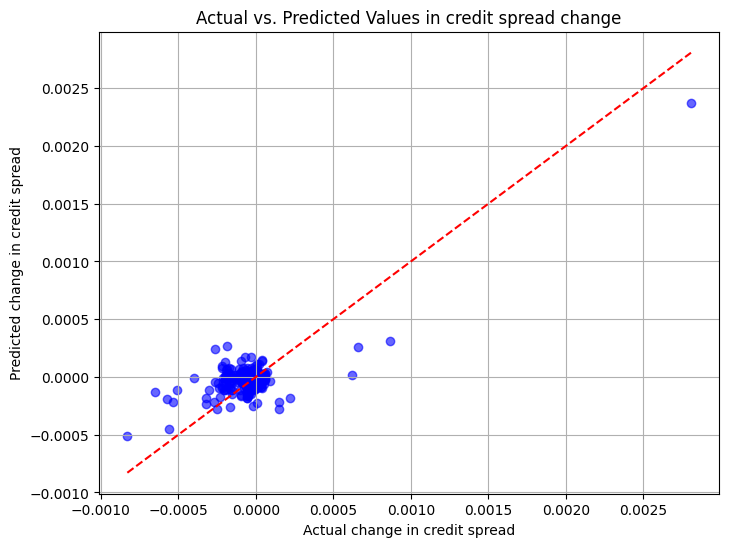

In [9]:
import matplotlib.pyplot as plt

# Get predicted values from the model
y_pred = cs_model.fittedvalues

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_cs, y_pred, alpha=0.6, color='blue')
plt.plot([y_cs.min(), y_cs.max()], [y_cs.min(), y_cs.max()], color='red', linestyle='--')
plt.title("Actual vs. Predicted Values in credit spread change")
plt.xlabel("Actual change in credit spread")
plt.ylabel("Predicted change in credit spread")
plt.grid(True)
# plt.ylim(-10, +10)
# plt.xlim(-25, +25)
plt.show()

### Step 2 - Newey West

In [10]:
eq_df = pd.read_csv("working_sample_2.csv")

print(eq_df.head())

   Unnamed: 0        date  isin  cs_change  delta lr  change_in_10y_bond  \
0           0  2022-11-30     0   -0.00267  0.000058            -0.00028   
1           1  2022-12-31     0   -0.00102  0.000058             0.00517   
2           2  2023-01-31     0   -0.00020  0.000024            -0.00310   
3           3  2023-02-28     0    0.00077  0.000024             0.00167   
4           4  2023-03-31     0    0.00259  0.000024            -0.00229   

   change_in_slope  smi_return  v3x_change rating  maturity  cpi_change  \
0         -0.00395    0.027314   -0.030361    AAA      10.0      0.0040   
1          0.00171   -0.036456   -0.005036    AAA      10.0     -0.2283   
2         -0.00158    0.050557    0.005429    AAA      10.0      0.6286   
3         -0.00069   -0.016747   -0.001126    AAA      10.0      0.7838   
4         -0.00179    0.000710   -0.016202    AAA      10.0      0.1623   

   unempl_change  gdp_change  liquidity  credit_rating_numeric  \
0            0.1    0.2605

In [11]:
eq_df_clean = eq_df.drop(columns="Unnamed: 0")
print(eq_df_clean.head())

         date  isin  cs_change  delta lr  change_in_10y_bond  change_in_slope  \
0  2022-11-30     0   -0.00267  0.000058            -0.00028         -0.00395   
1  2022-12-31     0   -0.00102  0.000058             0.00517          0.00171   
2  2023-01-31     0   -0.00020  0.000024            -0.00310         -0.00158   
3  2023-02-28     0    0.00077  0.000024             0.00167         -0.00069   
4  2023-03-31     0    0.00259  0.000024            -0.00229         -0.00179   

   smi_return  v3x_change rating  maturity  cpi_change  unempl_change  \
0    0.027314   -0.030361    AAA      10.0      0.0040            0.1   
1   -0.036456   -0.005036    AAA      10.0     -0.2283            0.1   
2    0.050557    0.005429    AAA      10.0      0.6286            0.1   
3   -0.016747   -0.001126    AAA      10.0      0.7838            0.0   
4    0.000710   -0.016202    AAA      10.0      0.1623           -0.1   

   gdp_change  liquidity  credit_rating_numeric     rating_class  \
0    0

In [12]:
# Store bond-wise coefficients
bond_coefs = {}

for bond_id, group in eq_df_clean.groupby('isin'):
    
    X = sm.add_constant(group[['delta lr', 'change_in_10y_bond', 'change_in_slope', 'smi_return', 'v3x_change', 'cpi_change', 'unempl_change', 'gdp_change', 'liquidity', 'stock_return']])
    y = group['cs_change']
    model = sm.OLS(y, X).fit()
    bond_coefs[bond_id] = model.params

# Convert to DataFrame
coef_df = pd.DataFrame(bond_coefs).T  # rows = bonds, columns = coefficients

# Average coefficients across bonds
avg_coefs = coef_df.mean()

In [13]:
print(coef_df.head())

      const  delta lr  change_in_10y_bond  change_in_slope  smi_return  \
0  0.000417 -5.183878           -0.209320         0.228491   -0.001674   
1  0.000469 -0.217499           -0.097182         0.055432    0.001779   
2  0.000713  0.136594           -0.172419         0.319099   -0.005362   
3 -0.000076  0.014582           -0.370100         0.294598    0.007366   
4 -0.000179 -0.035342           -0.171555         0.395429    0.007010   

   v3x_change  cpi_change  unempl_change  gdp_change  liquidity  stock_return  
0   -0.009516    0.000906      -0.000532   -0.004470  -0.000040     -0.003873  
1    0.002457    0.000574      -0.000384   -0.000624  -0.000809     -0.006320  
2   -0.011936    0.001206       0.001189   -0.002660  -0.001061     -0.012301  
3    0.028126    0.000882      -0.000284   -0.001619   0.000141     -0.014225  
4    0.010327    0.000894      -0.000181   -0.000638   0.000204     -0.014615  


In [14]:
# Say we want to explain average return per bond
bond_avg_y = eq_df_clean.groupby('isin')['cs_change'].mean()

# Merge into one DataFrame
crosssec_df = coef_df.copy()
crosssec_df['avg_cs_change'] = bond_avg_y

In [15]:
X_cs = sm.add_constant(crosssec_df[['delta lr', 'change_in_10y_bond', 'change_in_slope', 'smi_return', 'v3x_change', 'cpi_change', 'unempl_change', 'gdp_change', 'liquidity', 'stock_return']])  # regressors: time-series betas
y_cs = crosssec_df['avg_cs_change']                        # response: avg bond return
cs_model = sm.OLS(y_cs, X_cs).fit()

print(cs_model.summary())

                            OLS Regression Results                            
Dep. Variable:          avg_cs_change   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     15.44
Date:                Tue, 27 May 2025   Prob (F-statistic):           4.29e-20
Time:                        15:27:02   Log-Likelihood:                 1613.2
No. Observations:                 202   AIC:                            -3204.
Df Residuals:                     191   BIC:                            -3168.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -5.15e-05   1.01

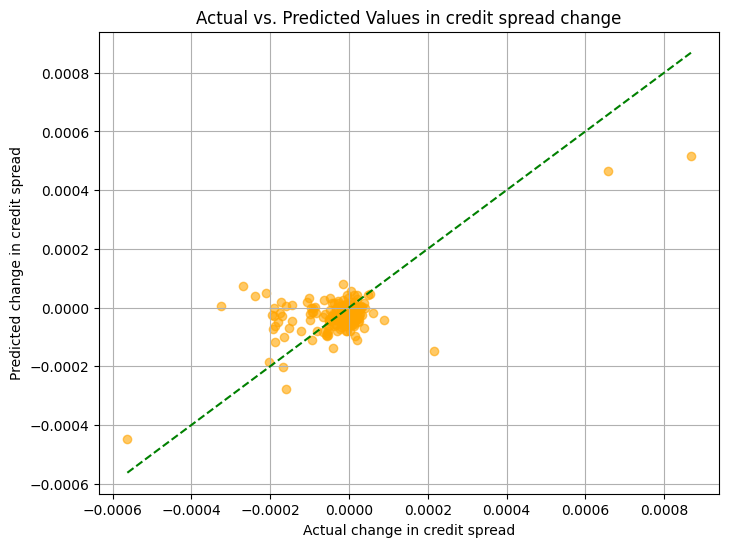

In [16]:
# Get predicted values from the model
y_pred = cs_model.fittedvalues

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_cs, y_pred, alpha=0.6, color='orange')
plt.plot([y_cs.min(), y_cs.max()], [y_cs.min(), y_cs.max()], color='green', linestyle='--')
plt.title("Actual vs. Predicted Values in credit spread change")
plt.xlabel("Actual change in credit spread")
plt.ylabel("Predicted change in credit spread")
plt.grid(True)
# plt.ylim(-10, +10)
# plt.xlim(-25, +25)
plt.show()

In [17]:
cs_model.rsquared

np.float64(0.44708345957377105)